In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.visualization import MinMaxInterval
import cv2
import os

import keras
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

## Reading a FITS file

In [62]:
#img_path = '/home/viviane/BLF_training/Images/EUC_J/imageEUC_J-200001.fits'
img_path = '/home/vivianemm/BLF/Images/EUC_J/imageEUC_J-200001.fits'
fits.info(img_path)

Filename: /home/vivianemm/BLF/Images/EUC_J/imageEUC_J-200001.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      29   (66, 66)   float32   


In [63]:
### using fits.getdata() --> np array
img_data = fits.getdata(img_path, ext=0)
print(img_data)

[[-9.76715930e-12  5.15664941e-12  1.09206437e-11 ... -5.59254899e-12
  -3.11408560e-12  4.89244192e-12]
 [-1.53540358e-11  1.29798325e-11 -2.45361175e-12 ...  7.96089583e-12
  -1.83813902e-11 -2.78579763e-12]
 [ 1.88017896e-12  9.41518478e-12  6.43359443e-13 ...  9.76120226e-13
   5.17626610e-12 -4.57186676e-12]
 ...
 [-6.50529934e-12  1.61818284e-11  7.76066971e-12 ... -5.27057131e-12
   5.44669128e-12  9.69319460e-13]
 [ 1.20240528e-11 -1.82952351e-12  2.04764972e-11 ...  1.14301635e-12
   1.23559182e-12 -1.11187286e-12]
 [ 2.80688558e-12 -8.62631754e-12  4.48427536e-12 ...  4.49563910e-12
   4.55615884e-12  3.62280019e-12]]


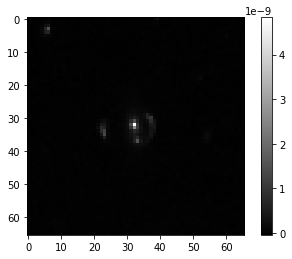

In [64]:
plt.figure()
plt.imshow(img_data, cmap='gray')
plt.colorbar()

In [65]:
# or using fits.open()  --> HDU object
hdul = fits.open(img_path)
img_data2 = hdul[0].data  # nparray
hdul[0].header
#hdul.close()

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                   66 / length of data axis 1                          
NAXIS2  =                   66 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
WCSAXES =                    2 / number of World Coordinate System axes         
CRPIX1  =                 33.5 / x-coordinate of reference pixel                
CRPIX2  =                 33.5 / y-coordinate of reference pixel                
CRVAL1  =                   0. / first axis value at reference pixel            
CRVAL2  =                   

### Pre processing

In [13]:
import os

In [55]:
# files in folders
files_H = os.listdir("/home/vivianemm/BLF/Images/EUC_H")
files_J = os.listdir("/home/vivianemm/BLF/Images/EUC_J")
files_VIS = os.listdir("/home/vivianemm/BLF/Images/EUC_VIS")
files_Y = os.listdir("/home/vivianemm/BLF/Images/EUC_Y")
file_paths_H = ['/home/vivianemm/BLF/Images/EUC_H/'+ file for file in files_H]  # has .pngs and .fits files
file_paths_J = ['/home/vivianemm/BLF/Images/EUC_J/'+ file for file in files_J]
file_paths_VIS = ['/home/vivianemm/BLF/Images/EUC_VIS/'+ file for file in files_VIS]
file_paths_Y = ['/home/vivianemm/BLF/Images/EUC_Y/'+ file for file in files_Y]

# paths in csv
catalog = pd.read_csv('/home/vivianemm/GravLens/Database/blf_complete.csv', comment='#')
paths_H = list(catalog['img_path_H'])
paths_J = list(catalog['img_path_J'])
paths_VIS = list(catalog['img_path_VIS'])
paths_Y = list(catalog['img_path_Y'])


# filter H
intersection_H = list(set(file_paths_H) & set(paths_H))
inter_H = pd.DataFrame(intersection_H)
inter_H.columns = ['img_path_H']

result_H = pd.merge(catalog, inter_H, how='inner', on=['img_path_H'])


# filter J
intersection_J = list(set(file_paths_J) & set(paths_J))
inter_J = pd.DataFrame(intersection_J)
inter_J.columns = ['img_path_J']
result_HJ = pd.merge(result_H, inter_J, how='inner', on=['img_path_J'])

# filter VIS
intersection_VIS = list(set(file_paths_VIS) & set(paths_VIS))
inter_VIS = pd.DataFrame(intersection_VIS)
inter_VIS.columns = ['img_path_VIS']
result_HJV = pd.merge(result_HJ, inter_VIS, how='inner', on=['img_path_VIS'])

# filter Y
intersection_Y = list(set(file_paths_Y) & set(paths_Y))
inter_Y = pd.DataFrame(intersection_Y)
inter_Y.columns = ['img_path_Y']
result_HJVY = pd.merge(result_HJV, inter_Y, how='inner', on=['img_path_Y'])

result_HJVY

,ID,x_crit,y_crit,source_ID,z_source,z_lens,mag_source,ein_area,n_crit,r_source,...,n_gal_5,n_gal_10,halo_mass,star_mass,mag_lens,n_sources,img_path_H,img_path_J,img_path_VIS,img_path_Y
0,200001,3.467590e-07,1.388970e-07,5131,1.96,0.699792,22.0469,3.714770e-10,19,3.259740e-06,...,2,5,5.046820e+13,6.426010e+11,20.2312,1,/home/vivianemm/BLF/Images/EUC_H/imageEUC_H-20...,/home/vivianemm/BLF/Images/EUC_J/imageEUC_J-20...,/home/vivianemm/BLF/Images/EUC_VIS/imageEUC_VI...,/home/vivianemm/BLF/Images/EUC_Y/imageEUC_Y-20...
1,200002,2.440650e-07,-2.128040e-07,7183,1.96,0.522781,25.4845,5.677310e-10,12,3.097520e-06,...,0,4,1.027460e+14,8.192230e+11,18.9784,1,/home/vivianemm/BLF/Images/EUC_H/imageEUC_H-20...,/home/vivianemm/BLF/Images/EUC_J/imageEUC_J-20...,/home/vivianemm/BLF/Images/EUC_VIS/imageEUC_VI...,/home/vivianemm/BLF/Images/EUC_Y/imageEUC_Y-20...
2,200003,4.086340e-07,2.556650e-07,4746,2.10,0.684567,25.4078,1.857780e-09,41,1.691660e-05,...,2,10,4.105040e+14,1.151740e+12,19.2772,0,/home/vivianemm/BLF/Images/EUC_H/imageEUC_H-20...,/home/vivianemm/BLF/Images/EUC_J/imageEUC_J-20...,/home/vivianemm/BLF/Images/EUC_VIS/imageEUC_VI...,/home/vivianemm/BLF/Images/EUC_Y/imageEUC_Y-20...
3,200004,7.584890e-08,-1.600640e-08,4426,1.93,0.540055,25.6997,7.307720e-10,24,1.506090e-05,...,4,9,1.729910e+14,4.497190e+11,19.1146,1,/home/vivianemm/BLF/Images/EUC_H/imageEUC_H-20...,/home/vivianemm/BLF/Images/EUC_J/imageEUC_J-20...,/home/vivianemm/BLF/Images/EUC_VIS/imageEUC_VI...,/home/vivianemm/BLF/Images/EUC_Y/imageEUC_Y-20...
4,200005,2.980050e-07,3.114750e-07,3389,2.62,0.734329,26.0315,6.982860e-10,23,6.095680e-06,...,3,9,7.507740e+13,8.194420e+11,20.3108,1,/home/vivianemm/BLF/Images/EUC_H/imageEUC_H-20...,/home/vivianemm/BLF/Images/EUC_J/imageEUC_J-20...,/home/vivianemm/BLF/Images/EUC_VIS/imageEUC_VI...,/home/vivianemm/BLF/Images/EUC_Y/imageEUC_Y-20...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99986,299996,8.426930e-08,4.142970e-07,9732,2.33,0.454103,27.6100,2.289920e-10,22,1.108540e-05,...,4,6,2.217870e+13,3.244700e+11,19.3234,1,/home/vivianemm/BLF/Images/EUC_H/imageEUC_H-29...,/home/vivianemm/BLF/Images/EUC_J/imageEUC_J-29...,/home/vivianemm/BLF/Images/EUC_VIS/imageEUC_VI...,/home/vivianemm/BLF/Images/EUC_Y/imageEUC_Y-29...
99987,299997,-5.844760e-08,-2.954790e-07,3872,2.51,1.020240,27.0104,1.044180e-10,17,2.699780e-06,...,1,3,1.116210e+13,4.611810e+11,22.4231,1,/home/vivianemm/BLF/Images/EUC_H/imageEUC_H-29...,/home/vivianemm/BLF/Images/EUC_J/imageEUC_J-29...,/home/vivianemm/BLF/Images/EUC_VIS/imageEUC_VI...,/home/vivianemm/BLF/Images/EUC_Y/imageEUC_Y-29...
99988,299998,1.750520e-07,-3.489430e-07,1479,2.34,0.880956,26.9190,2.586480e-10,14,5.093080e-06,...,2,5,2.244270e+13,6.148510e+11,21.2026,1,/home/vivianemm/BLF/Images/EUC_H/imageEUC_H-29...,/home/vivianemm/BLF/Images/EUC_J/imageEUC_J-29...,/home/vivianemm/BLF/Images/EUC_VIS/imageEUC_VI...,/home/vivianemm/BLF/Images/EUC_Y/imageEUC_Y-29...
99989,299999,-1.074260e-07,-1.454120e-07,5679,3.34,1.018260,27.5704,3.439960e-10,11,6.165830e-06,...,1,3,2.956680e+13,8.741080e+11,21.6255,1,/home/vivianemm/BLF/Images/EUC_H/imageEUC_H-29...,/home/vivianemm/BLF/Images/EUC_J/imageEUC_J-29...,/home/vivianemm/BLF/Images/EUC_VIS/imageEUC_VI...,/home/vivianemm/BLF/Images/EUC_Y/imageEUC_Y-29...


## Creating a network

In [64]:
import gc
from keras.preprocessing.image import img_to_array
from imutils import paths
from sklearn.preprocessing import MultiLabelBinarizer
import cv2
import os

# reads png images (filter given in parameters)
# filters: H, J, VIS, Y

def get_data(IMAGE_DIMS):
    
    blf = result_HJVY
    blf_0 = blf[blf['n_sources'] == 0]  # not lens  ->  minority class
    blf_1 = blf[blf['n_sources'] == 1]  # lens
    
    ######## blf 0 #########
    imgs_0 = np.zeros((len(blf_0), IMAGE_DIMS[1], IMAGE_DIMS[0], 4))
    filter_cont = 0
    
    for filter in ['H', 'J', 'VIS', 'Y']:
        
        imgs = []
        for path in blf_0['img_path_{}'.format(filter)]:

                image = cv2.imread(path)
                image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
                gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                image = img_to_array(gray)
                image = image / 255.0  # normalizing (between 0 and 1)

                imgs.append(image)
            
        
        imgs = np.array(imgs)
        imgs = np.reshape(imgs, (imgs.shape[0], imgs.shape[1], imgs.shape[2] ))
        imgs_0[:,:,:,filter_cont] = imgs
        filter_cont += 1 

    labels_0 = np.array(blf_0['n_sources'])
    
    
    ######### blf 1 ##########
    blf_1 = blf_1.sample(n=len(blf_0), random_state=1)
    imgs_1 = np.zeros((len(blf_0), IMAGE_DIMS[1], IMAGE_DIMS[0], 4))
   
    cont = 0
    for filter in ['H', 'J', 'VIS', 'Y']:
        
        imgs = []
        for path in blf_1['img_path_{}'.format(filter)]:
            image = cv2.imread(path)
            image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            image = img_to_array(gray)
            image = image / 255.0  # normalizing (between 0 and 1)

            imgs.append(image)
            
        
        imgs = np.array(imgs)
        imgs = np.reshape(imgs, (imgs.shape[0], imgs.shape[1], imgs.shape[2] ))
        imgs_1[:,:,:,cont] = imgs
        cont += 1 

    labels_1 = np.array(blf_1['n_sources'])
    
    ####### concatenating imgs and labels from blf_0 and blf_1 #######
    imgs = np.concatenate((imgs_0, imgs_1), axis=0)
    labels = np.concatenate((labels_0, labels_1), axis=0)
    
    
    return imgs, labels

In [65]:
imgs, labels = get_data((66,66))

(10004, 66, 66)
(10004, 66, 66)
(10004, 66, 66)
(10004, 66, 66)


In [6]:
#imgs = np.load('/home/vivianemm/imagens.npy')
#labels = np.load("labels.npy")

In [7]:
def balance(labels, imgs):
    a = np.unique(labels, return_counts=True)
    n_lens = a[1][0]

    b = np.where(labels == 1)
    b[0].shape
    r = np.random.choice(b[0], n_lens)

    lens = np.where(labels == 0)

    indices = np.concatenate((r, lens), axis=None)  # indices dos elementos que serao utilizados
    
    labels = labels[indices]
    imgs = imgs[indices,]
        
    return labels, imgs

In [75]:
np.save("images.npy", imgs)
np.save("labels.npy", labels)

In [66]:
# Splitting dataset into training, validation and test data    model = Sequential()
    model.add(Conv2D(32, kernel_size = (11,11), input_shape = (66,66,4), activation = "relu"))
    model.add(Dropout(1/3.0))
    model.add(Conv2D(64, kernel_size = (5,5), activation = "relu"))
    model.add(Dropout(1/3.0))
    model.add(Conv2D(64, kernel_size = (3,3), activation = "relu"))
    model.add(Dropout(1/3.0))
    model.add(Flatten())
    model.add(Dense(256, activation = "relu"))
    model.add(Dropout(1/2.0))
    model.add(Dense(64, activation = "relu"))
    model.add(Dropout(1/2.0))
    model.add(Dense(1, activation = "sigmoid"))
imgs, imgs_test, labels, labels_test = train_test_split(imgs, labels, test_size=0.1, random_state=42)
imgs, imgs_val, labels, labels_val = train_test_split(imgs, labels, test_size=0.30, random_state=42)

(2001, 66, 66, 4)

In [ ]:
# Data augmentation
aug = ImageDataGenerator(rotation_range=180, width_shift_range=0.1, height_shift_range=0.1, 
                         shear_range=0.1, zoom_range=0.1, fill_mode='nearest',
                         horizontal_flip=True, vertical_flip=True)

In [71]:
def model():
    
    model = Sequential()
    model.add(Conv2D(32, kernel_size = (11,11), input_shape = (66,66,4), activation = "relu"))
    model.add(Dropout(1/3.0))
    model.add(Conv2D(64, kernel_size = (5,5), activation = "relu"))
    model.add(Dropout(1/3.0))
    model.add(Conv2D(64, kernel_size = (3,3), activation = "relu"))
    model.add(Dropout(1/3.0))
    model.add(Flatten())
    model.add(Dense(256, activation = "relu"))
    model.add(Dropout(1/2.0))
    model.add(Dense(64, activation = "relu"))
    model.add(Dropout(1/2.0))
    model.add(Dense(1, activation = "sigmoid"))
    
    return model

In [72]:
modelo = model()
modelo.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [73]:
#modelo.summary()

In [ ]:
from keras.optimizers import Adam
learning_rate = 10**(-3)
opt = Adam(lr = learning_rate, decay = (1/0.99 - 1)/(imgs.shape[0]/32))

In [ ]:
history = modelo.fit_generator(aug.flow(imgs,labels), epochs=300, validation_data = (imgs_val, labels_val))

In [ ]:
def plot_loss(model):
    
    plt.plot(np.arange(0, 30), history.history["loss"], label = "training loss")
    plt.plot(np.arange(0, 30), history.history["val_loss"], label = "Validation loss")
    plt.xlabel("Epoch")
    plt.legend(loc="upper left")
    plt.show()
    
    return None

In [80]:
#plt.plot(np.arange(0, 30), history.history["acc"], label = "Erro de trainamento")
#plt.plot(np.arange(0, 30), history.history["val_acc"], label = "Erro de validação")
#plt.xlabel("Epoch")
#plt.legend(loc="upper left")
#plt.show()

In [81]:
def model_alt():
    
    model = Sequential()
    model.add(Conv2D(55, kernel_size = (3,3), input_shape = (66,66,3), activation = "relu"))
    model.add(Conv2D(32, kernel_size = (3,3), activation = "relu"))
    model.add(Conv2D(52, kernel_size = (3,3), activation = "relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(25, activation = "relu"))
    model.add(Dense(15, activation = "relu"))
    model.add(Dense(1, activation = "sigmoid"))
    
    return model

In [82]:
modelo_alt = model_alt()

In [83]:
modelo_alt.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])
history_alt = modelo_alt.fit(imgs,labels, epochs=30, validation_data = (imgs_val, labels_val))

ValueError: Error when checking input: expected conv2d_7_input to have shape (66, 66, 1) but got array with shape (66, 66, 3)

In [ ]:
plt.plot(np.arange(0, 30), history_alt.history["loss"], label = "Loss modelo alt")
plt.plot(np.arange(0, 30), history.history["loss"], label = "Loss")
plt.xlabel("Epoch")
plt.legend(loc="upper left")
plt.show()

In [ ]:
plt.plot(np.arange(0, 30), history_alt.history["val_loss"], label = "val_loss alt")
plt.plot(np.arange(0, 30), history.history["val_loss"], label = "Val_loss")
plt.xlabel("Epoch")
plt.legend(loc="upper left")
plt.show()

In [ ]:
a = pd.read_csv('Database/blf_complete.csv', comment="#")
a.set_index(a['ID'])
a #['img_path_H'] #[213913]

# Tables

#### Separar features e target
#### Verificar se existem váriaveis categóricas -> mapear para 0,1 (duas classes) ou one-hot-encoding (mais classes)
#### Tratar dados faltantes
#### Normalização
#### Balanceamento
#### Split -> treino, validação e teste
#### Utilizar camadas densas no modelo

In [235]:
def get_data_table():
    
    blf = pd.read_csv('Database/blf_complete.csv', comment="#")
    blf = blf.dropna()
    blf.reset_index(inplace=True, drop=True)
    labels = np.array(blf['n_sources'])
    blf.drop(['n_sources', 'source_ID', 'ID'], inplace=True, axis=1)
    blf.drop(['img_path_H', 'img_path_J', 'img_path_VIS', 'img_path_Y'], inplace=True, axis=1)
    
    blf.drop(['x_crit', 'y_crit', 'n_crit', 'r_source', 'crit_area', 'ein_area', 'n_gal_3', 'n_gal_5',
             'n_gal_10', 'halo_mass', 'star_mass', 'n_source_im', 'n_pix_lens', 'sb_contrast', 'n_pix_source',
             'mag_source', 'mag_lens', 'mag_eff', 'color_diff', 'z_source', 'z_lens'], inplace=True, axis=1)
    
    blf = (blf-blf.min())/(blf.max()-blf.min())  # normalizing (0 to 1)
    
    return blf, labels


In [246]:
features, labels = get_data_table()

In [237]:
features.columns

Index(['source_flux', 'lens_flux'], dtype='object')

In [ ]:
from ggplot import *
#plt.plot(features['source_flux'], features['lens_flux'], c = labels)

ggplot(aes(x='source_flux', y='lens_flux', color=labels), data=features)  + geom_point()

In [238]:
def balance_table(features, labels):
    
    features = features.to_numpy()
    
    not_lens = np.unique(labels, return_counts=True)[1][0]  # number of 0's

    lens_index = np.where(labels == 1)
    lens_index[0].shape
    sample_lens = np.random.choice(lens_index[0], not_lens)

    not_lens_index = np.where(labels == 0)

    indices = np.concatenate((sample_lens, not_lens_index), axis=None)  # indices dos elementos que serao utilizados
    
    labels = labels[indices]
    features = features[indices,]
        
    return features, labels

In [239]:
features, labels = balance_table(features, labels)

In [240]:
features, features_test, labels, labels_test = train_test_split(features, labels, test_size=0.1, random_state=42)
features, features_val, labels, labels_val = train_test_split(features, labels, test_size=0.30, random_state=42)

In [241]:
def model_table():
    
    model = Sequential()
    #model.add(Dense(25, activation = "relu"))
    model.add(Dense(5, activation = "relu"))
    model.add(Dense(1, activation = "sigmoid"))
    
    return model

In [242]:
model_t = model_table()

In [243]:
model_t.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [244]:
history = model_t.fit(features,labels, epochs=30, validation_data = (features_val, labels_val))

Train on 55955 samples, validate on 23982 samples
Epoch 1/30
55955/55955 [==============================] - 2s 40us/step - loss: 0.1184 - accuracy: 0.9989 - val_loss: 0.0056 - val_accuracy: 1.0000
Epoch 2/30
55955/55955 [==============================] - 2s 36us/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 9.3950e-04 - val_accuracy: 1.0000
Epoch 3/30
55955/55955 [==============================] - 2s 37us/step - loss: 5.2172e-04 - accuracy: 1.0000 - val_loss: 2.6579e-04 - val_accuracy: 1.0000
Epoch 4/30
55955/55955 [==============================] - 2s 35us/step - loss: 1.5984e-04 - accuracy: 1.0000 - val_loss: 8.8737e-05 - val_accuracy: 1.0000
Epoch 5/30
55955/55955 [==============================] - 2s 37us/step - loss: 5.5166e-05 - accuracy: 1.0000 - val_loss: 3.1763e-05 - val_accuracy: 1.0000
Epoch 6/30
55955/55955 [==============================] - 2s 36us/step - loss: 2.0061e-05 - accuracy: 1.0000 - val_loss: 1.1760e-05 - val_accuracy: 1.0000
Epoch 7/30
55955/55955 [========

In [234]:
model_t.evaluate(features_test, labels_test)

8882/8882 [==============================] - 0s 12us/step


[1.0148236533932561e-09, 1.0]

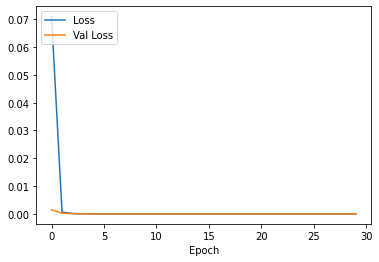

In [219]:
plt.plot(np.arange(0, 30), history.history["loss"], label = "Loss")
plt.plot(np.arange(0, 30), history.history["val_loss"], label = "Val Loss")
plt.xlabel("Epoch")
plt.legend(loc="upper left")
plt.show()